# Exercício de Programação: PCA

<font color="red">**Prazo de submissão: 23:59 do dia 30/05/2025** </font>

2025.1 Álgebra Linear Computacional - DCC - UFMG

Erickson

Instruções:
* Antes de submeter suas soluções, certifique-se de que tudo roda como esperado. Primeiro, **reinicie o kernel** no menu, selecione Kernel$\rightarrow$Restart e então execute **todas as células** (no menu, Cell$\rightarrow$Run All)
* Apenas o arquivo .ipynb deve ser submetido. Ele não deve ser compactado.
* Não deixe de preencher seu nome e número de matrícula na célula a seguir

**Nome dos alunos e matrícula:**  
INSIRA Nome1: Letícia Ruas de Lucca Rodrigues, Matricula1: 2024023848  
INSIRA Nome2: Lívia Caroline Rodrigues Pereira, Matricula2: 2024024003  

Nesta lista, a parte inicial é apenas para sua orientação. Ela mostra um sistema de classificação de faces em fotos e você não precisa entregar nada acerca desta parte inicial.  O que você precisa entregar ́é um exercício quase idêntico para classificar dígitos manuscritos usando a mesma técnica desta parte inicial. Veja a seção **Exercício** no final deste documento.

In [3]:
# Para abrir os arquivos, mude o caminho para onde as pastas "images" e "DadosYalesFaces" estão.
from google.colab import drive
from IPython.display import Image, display

drive.mount('/content/drive')

caminho = "/content/drive/My Drive/EP1"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Tutorial de reconhecimento de faces usando PCA - Eigenfaces

O arquivo ```DadosYaleFaces.zip```, na pasta ```data```, contem diretórios com arquivos de fotos de 15 indivíduos, um diretório para cada indivíduo. Dentro deles, temos 11 fotos de cada indivíduo. As fotos variam de acordo com aspectos tais como iluminação, expressão (sorrindo, sério, triste), pela presença de óculos ou não. A Figura 1 exibe uma amostra dessas fotos. Cada linha de fotos corresponde a um indivíduo.  As imagens são normalizadas para alinhar os olhos e bocas. Eles aparecem mais ou menos no mesmo local na imagem.

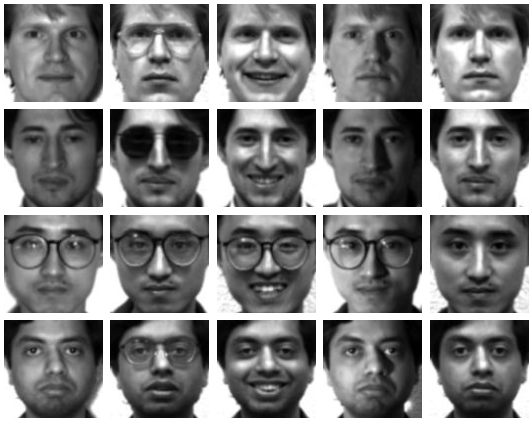

In [4]:
display(Image(filename=(caminho + '/images/SampleFaces.png')))


<div style="text-align:center"><img src="images/SampleFaces.png" /><br>
    <em>Figura 1: Amostra de 5 fotos de 4 indivíduos.</em></div>


Vamos fazer uma análise das fotos via componentes principais com o objetivo de reconhecer estes rostos. Imagine que você tenha uma base de dados com várias fotos de um conjunto de indivíduos. Você vai especificar um sistema de vigilância para uma companhia e apenas os 15 indivíduos destas fotos podem entrar num certo local. A checagem é feita automaticamente com uma nova foto tirada no momento da tentativa de entrada. Vamos usar o PCA para criar um sistema para classificar esta nova foto a uma das 15 classes representadas pelos diferentes indivíduos. Assim, o problema é: Chega uma nova foto. Queremos encontrar o rosto mais parecido com a nova foto no banco de dados. Se o rosto mais parecido não estiver próximo o suficiente da nova foto, a entrada não é permitida.

O  método das _autofaces_ foi proposto por Turk and Pentland (1991a, 1991b). Ele é principalmenteum método de redução de dimensionalidade, podendo representar muitos indivíduos com um conjunto relativamente pequeno de dados. A idéia é representar a foto de um rosto como uma soma de um rosto médio mais uma combinação linear de um pequeno número de pseudo-fotos, que são as _autofaces_.  Estas _autofaces_ são fotos embaçadas que capturam aspectos importantes da composição de uma face.

Podemos imaginar cada foto sendo aproximadamente obtida como representado na Figura 2.  As fotos à  esquerda são aproximadamente iguais a uma mesma foto média (a primeira do lado direito) mais quatro autofaces, cada uma delas multiplicada por um peso $w_{ij}$ que é específico do indivíduo. Diferentes indivíduos vão variar apenas nos 4 pesos $w_{ij}$ que cada autoface recebe. As autofaces são fixas e as mesmas para todos os indivíduos considerados, bem como a face média, que também é a mesma para todos

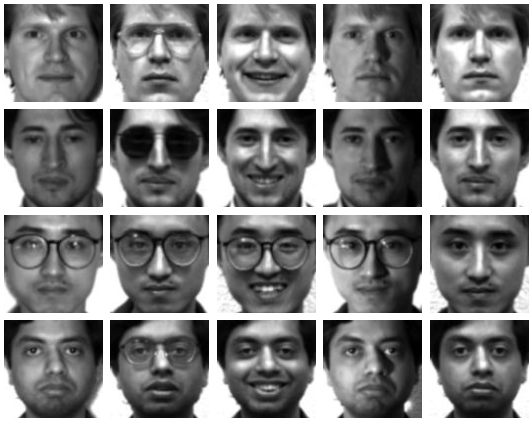

In [5]:
display(Image(filename=(caminho + '/images/SampleFaces.png')))


<div style="text-align:center"><img src="images/IdeiaAutoFaces.png" /><br>
    <em>Figura 2: Uma foto (a esquerda) é aproximandamente a soma de uma foto média mais quatro autofaces multiplicadas por pesos <img src="http://latex.codecogs.com/svg.latex?w_{ij}" border="0"/>
 específicos do indivíduo. Diferentes indivíduos vão variar apenas nos 4 pesos <img src="http://latex.codecogs.com/svg.latex?w_{ij}" border="0"/>
 que cada autoface recebe</em></div>

Primeiramente, vamos ler as fotos em Python. Vou usar a biblioteca Pillow que fornece algumas funcionalidades para processamento de imagens no Python. Informações em https://pillow.readthedocs.io/en/stable/. Essa biblioteca é baseada na bilbioteca Pil (Python Image Library). O script para instalar segue abaixo:

In [6]:
import sys
!{sys.executable} -m pip install --user Pillow scikit-learn

<font color="red">**Atenção caso o script não funcione basta executar o comando a seguir** </font>

```pip install Pillow scikit-learn```

pode ser necessário possuir permisões de administrador.

In [7]:
!pip install Pillow scikit-learn

A função ```open``` le imagens em um arquivo. Vamos carregar a imagem no arquivo **Faces3/s5.jpg** e visualizá-la.

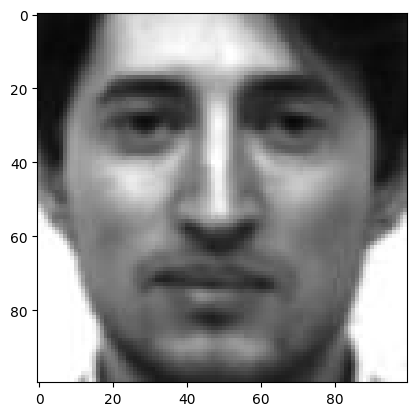

In [8]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

image = Image.open(caminho + '/DadosYaleFaces/Faces3/s5.jpg')
plt.imshow(image)

```image``` é um objeto do tipo Image da biblioteca Pillow. Com 100 $\times$ 100 pixels com 3 canais de cor, o usual RGB.

Podemos transformar o objeto ```image``` em um ```numpy.array``` e vice-versa. Vejam abaixo

Esse é o tamanho da imagem: Altura: 100  Largura: 100 Canais de cor: 3


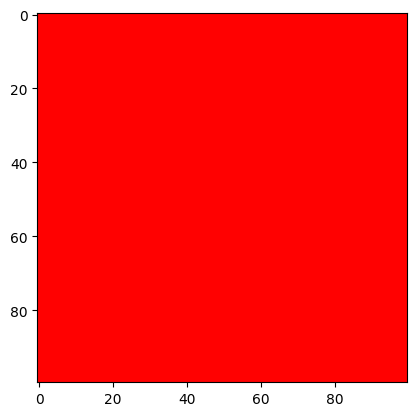

In [9]:
import numpy as np

#image to numpy.array
image = np.asarray(image)
print('Esse é o tamanho da imagem: Altura:',image.shape[0],' Largura:',image.shape[1],'Canais de cor:',image.shape[2])
#numpy.array to image
a = np.ones((100,100,3))
a[:,:,0] = a[:,:,0] * 255
i = Image.fromarray(np.uint8(a))
plt.imshow(i)

Agora iremos ler todas as fotos dos indivíduos. Existem 15 indivíduos separados em 15 diretório. E dentro de cada um desses diretórios possuem 11 imagens em formato ```jpg``` e ```bmp```. Cada uma dessas fotos correspondem a diferentes poses de um mesmo indivíduo.Vamos ver como fazer a leitura das fotos e armazenamento na lista **fotos**

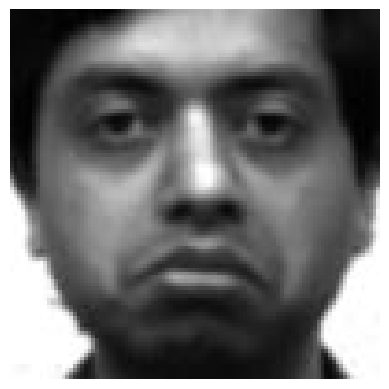

In [10]:
import os

fotos = []
for i in range(1,16):
    fotos_individuo = []
    for j in range(1,12):
        fotos_individuo.append(Image.open(caminho + '/DadosYaleFaces/Faces'+str(i)+'/s'+str(j)+'.jpg'))
    fotos.append(fotos_individuo)

##Podemos exibir a imagem 7 do individuo 9, com o comando
plt.axis('off')
plt.imshow(fotos[9][7])

Podemos observar algumas imagens aleatórias da seguinte maneira

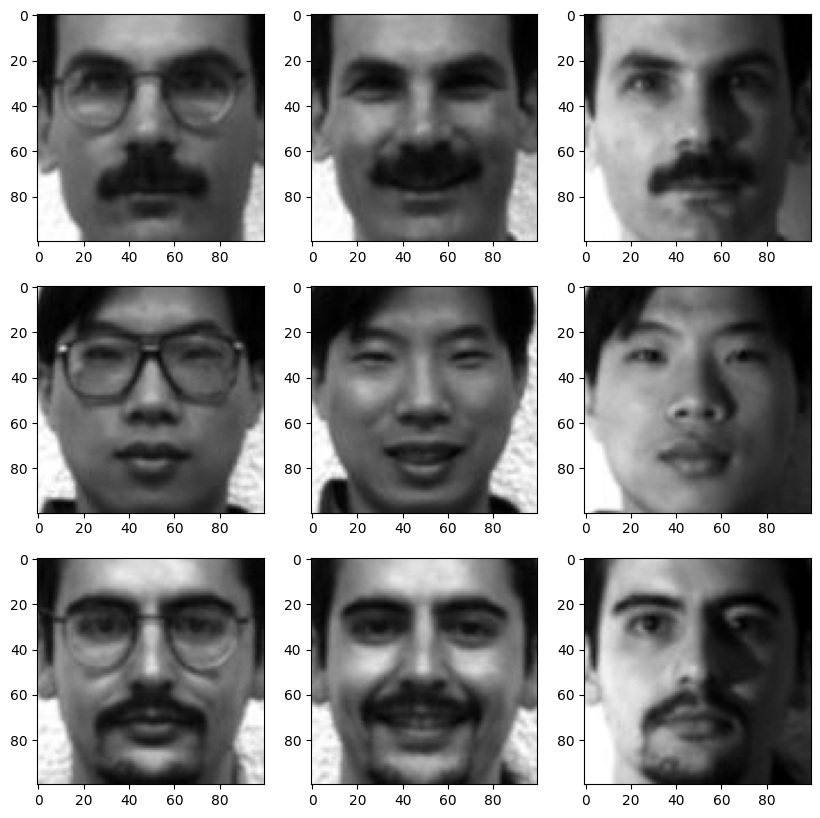

In [11]:
plt.figure(figsize=(10, 10))

plt.subplot(331)
plt.imshow(fotos[1][1])
plt.subplot(332)
plt.imshow(fotos[1][2])
plt.subplot(333)
plt.imshow(fotos[1][3])

plt.subplot(334)
plt.imshow(fotos[3][1])
plt.subplot(335)
plt.imshow(fotos[3][2])
plt.subplot(336)
plt.imshow(fotos[3][3])

plt.subplot(337)
plt.imshow(fotos[8][1])
plt.subplot(338)
plt.imshow(fotos[8][2])
plt.subplot(339)
plt.imshow(fotos[8][3])

plt.show()

Para a análise de componentes principais, vamos converter as fotos em matrizes e colocá-las numa lista ```fotosmat```

In [12]:
fotosmat = []
for i in range(15):
    fotosmat_individuo = []
    for j in range(11):
        fotosmat_individuo.append(np.asarray(fotos[i][j]))
    fotosmat.append(fotosmat_individuo)
fotosmat = np.asarray(fotosmat)

Todos os canais de cor das imagens são iguais, vocês podem confirmar isso com o código abaixo.

In [13]:
print(fotosmat[0][0][:,:,1] == fotosmat[0][0][:,:,2])

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


Agora iremos empilhar as colunas de cada uma das matrizes para montar uma matriz nova. Para isso iremos utilizar a função ```reshape``` passando o parâmetro ```order``` para utilizarmos a conveção adotada pela linguaguem de programação Fortran. Mais informações [https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html)

Logo como todos os canais de cor são iguais iremos utilizar apenas 1 deles para realizar os cálculos.

In [14]:
mat_pixels = []
for i in range(15):
    for j in range(11):
        mat_pixels.append(fotosmat[i][j][:,:,0].reshape((-1,1),order='F'))
mat_pixels = np.asarray(mat_pixels).T[0]
mat_pixels.shape

(10000, 165)

In [15]:
import random

random.seed(42)
idx = random.randint(0,11)
print('Retiraremos a imagem de número ',idx,' de cada indivíduo.')
#Agora iremos montar a matriz de teste para o nosso método.
idxs = [idx+(i*11) for i in range(15)]
mat_teste = mat_pixels[:,idxs]
mat_pixels = mat_pixels[:,[i for i in range(165) if i not in idxs]]

Retiraremos a imagem de número  10  de cada indivíduo.


Precisamos centrar todas as fotos do conjunto de treinamento subtraindo de cada foto a foto média de todo o conjunto de fotos. Esta foto média é simplesmente a $fotoÂ'Â'$ obtida tirando a média aritmética sobre o conjunto de fotos em cada pixel. Isto é, para um pixel localizado numa certa posição, tiramos a média de todos os valores observados naquela posição nas diferentes fotos do conjunto de treinamento.

In [16]:
mat_media = np.mean(mat_pixels,axis=1)
mat_centrada = (mat_pixels.T - mat_media.T).T

Vamos visualizar como é a nossa imagem média.

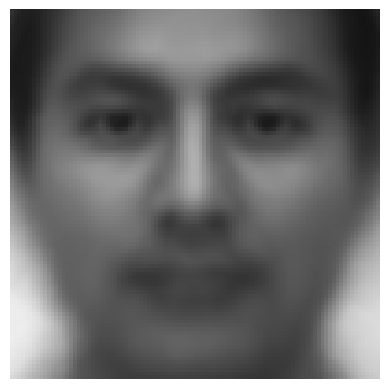

In [17]:
image = Image.fromarray(mat_media.reshape((100,100)).T)
plt.axis('off')
plt.imshow(image, cmap='gray')

Iremos utilizar o PCA para achar as principais componentes do nosso conjunto de dados. Iremos buscar pela quantidade de componentes que conseguem representar $90\%$ dos dados.

In [18]:
from sklearn.decomposition import PCA
pca = PCA(0.9)
pca.fit(mat_centrada.T)

#Quantas componentes não necessárias para representar os dados
print(pca.components_.shape)
#Podemos observar a contribuição de cada uma das componentes na representatividade dos dados
print(pca.explained_variance_ratio_ )
#Somando esses valores obtemos a nossa porcetagem.
print(np.sum(pca.explained_variance_ratio_ ))

print('utilizando os 10 primeiros componentes',np.sum(pca.explained_variance_ratio_[:10]))
print('utilizando os proximos 10 componentes',np.sum(pca.explained_variance_ratio_[:20]))

(26, 10000)
[0.20399713 0.18150999 0.13116882 0.0701215  0.04806165 0.03642303
 0.03046697 0.02647779 0.02222528 0.01778654 0.01550954 0.01422176
 0.01249448 0.01137386 0.00956269 0.00905978 0.00809801 0.00779198
 0.00743616 0.00685096 0.00587818 0.00583692 0.00518994 0.00507618
 0.00456907 0.00429453]
0.9014827462462526
utilizando os 10 primeiros componentes 0.7682386962723542
utilizando os proximos 10 componentes 0.870637926268776


Veja a variância explicada por cada um dos componentes. Os 10 primeiros PCs explicam $76\%$ da variação total.  Acrescentar mais 10, ficando com 20 PCs, leva a $86\%$. Vamos realizar observar melhor como a variação acrescentada por cada componente vai evoluindo com mais componentes.

Text(0.5, 0, 'Qtd Principais Componentes')

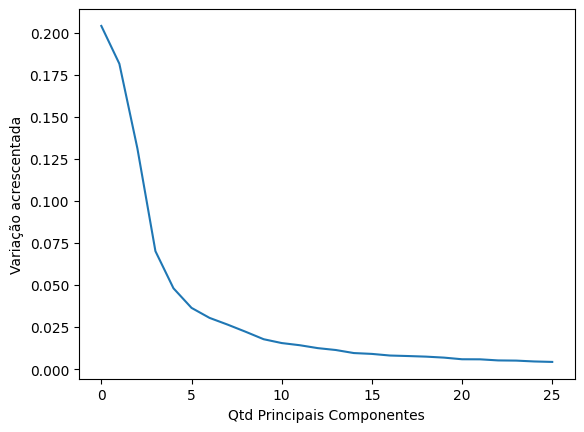

In [19]:
plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Variação acrescentada')
plt.xlabel('Qtd Principais Componentes')

In [20]:
autovalores = pca.explained_variance_
autovetores = pca.components_

Vamos criar agora as autofaces. Vamos desempilhar os autovetores quebrando a coluna de cada um delesem 100 colunas de tamanho 100 cada uma. Com isto, cada autovetor dá origem a uma $imagemÂ'Â'$ ́com a mesma quantidade de pixels que as fotos originais. Vamos chamar estas pseudo-fotos de **autofaces**. Iremos utilizar apenas os 20 primeiros autovetores para isso.

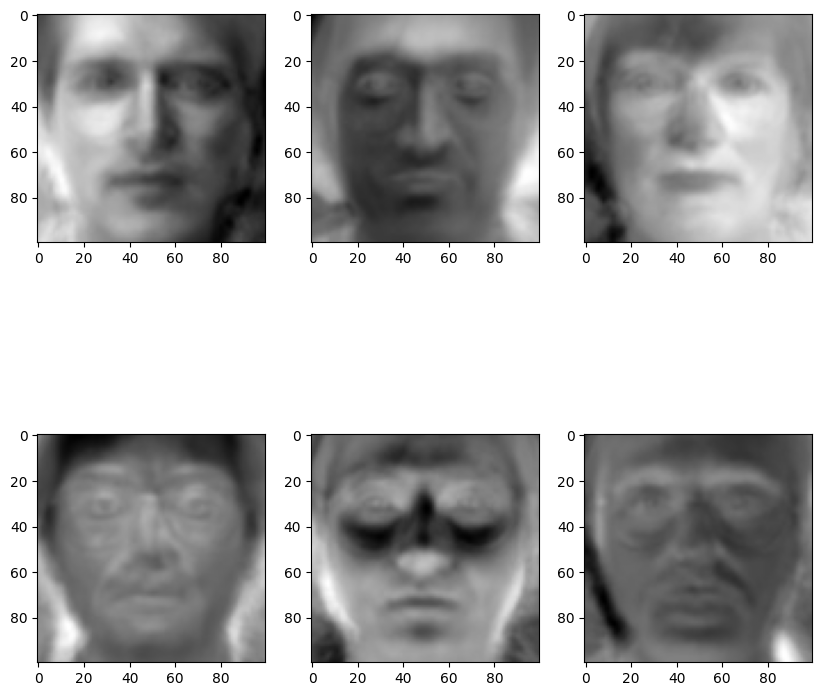

In [21]:
auto_faces = []
for i in range(20):
    auto_faces.append(pca.components_[i].reshape((100,100)))
auto_faces = np.asarray(auto_faces)
#Vamos ver algumas fotos
plt.figure(figsize=(10, 10))

plt.subplot(231)
plt.imshow(auto_faces[0].T, cmap='gray')
plt.subplot(232)
plt.imshow(auto_faces[1].T, cmap='gray')
plt.subplot(233)
plt.imshow(auto_faces[2].T, cmap='gray')

plt.subplot(234)
plt.imshow(auto_faces[3].T, cmap='gray')
plt.subplot(235)
plt.imshow(auto_faces[4].T, cmap='gray')
plt.subplot(236)
plt.imshow(auto_faces[5].T, cmap='gray')

plt.show()

Vamos visualizar uma face em **mat_teste** sua aproximação usando as $k$ primeiras autofaces. Para isto precisamos escrever uma foto como aproximadamente uma soma da foto média mais uma combinação linear das primeiras $k$ autofaces (todos como vetores). Em seguida, desempilhamos os vetores e mostramos as faces. Por exemplo, usando a face na coluna 5 de **mat_teste**.  Vamos obter os coeficientes $b_k$da combinação linear $mboxfoto≈fotomedia +b_1v_1+b_2v_2+. . .+b_kv_k$ Sabemos que $b_j$ é o produto interno dos vetores formados pela foto centrada com o autovetor $v_k$.  Então

In [22]:
coef = autovetores@((mat_teste[:,5].T - mat_media.T).T)

A variável ```coef``` possui agora os coeficientes para a representação da foto em questão no espaço gerado pelos 20 primeiros autovetores. Vamos observar agora as aproximações para a imagem utilizando 2,3,4 e 20 autovetores.

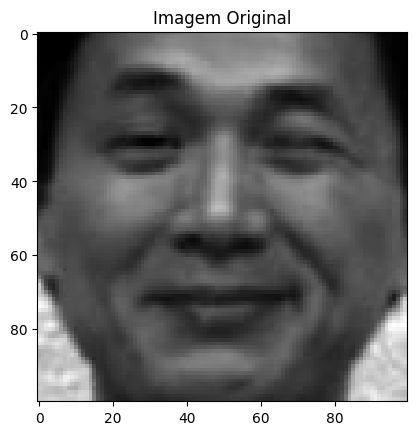

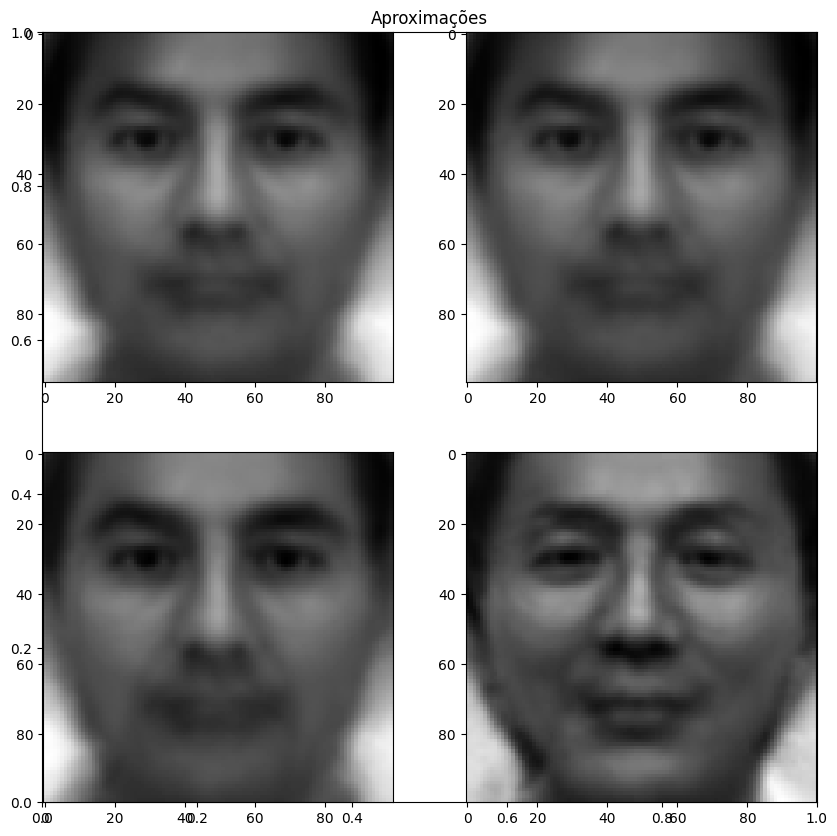

In [23]:
fotos_teste_5 = []
for i in [2,3,4,20]:
    vec_aproximado = mat_media + autovetores[:i,:].T@coef[:i]
    fotos_teste_5.append(vec_aproximado.reshape((100,100)))


plt.imshow(mat_teste[:,5].reshape((100,100)).T,cmap='gray')
plt.title('Imagem Original')

plt.figure(figsize=(10, 10))
plt.title('Aproximações')
plt.subplot(221)
plt.imshow(fotos_teste_5[0].T, cmap='gray')
plt.subplot(222)
plt.imshow(fotos_teste_5[1].T, cmap='gray')
plt.subplot(223)
plt.imshow(fotos_teste_5[2].T, cmap='gray')
plt.subplot(224)
plt.imshow(fotos_teste_5[3].T, cmap='gray')


Vamos realizar esse processo para todas as imagens no nosso conjunto de teste.

In [24]:
coef_teste = autovetores[:20,:]@((mat_teste.T - mat_media.T).T)

Como classificar cada uma destas 15 fotos em uma das categorias disponíveis, as categorias sendo os 15 indivíduos? Qual será a taxa de acerto deste sistema de classificação? Vamos primeiro obter arepresentação de cada uma das 150 fotos de treino nos 20 PCAs, exatamente como fizemos com as fotos de teste

In [25]:
coef_treino = autovetores[:20,:]@((mat_pixels.T - mat_media.T).T)

Vamos obter uma representação média de cada um dos 15 indivíduos. Vamos tirar a média dos coeficientes das 10 fotos de cada indivíduo

In [26]:
coef_medio = []
for i in range(1,16):
    coef_medio.append(np.mean(coef_treino[:,(i-1)*10:i*10],axis=1))
coef_medio = np.asarray(coef_medio).T

Agora para classificar as faces do conjunto de teste entre os indivíduos devemos olhar para ```coef_teste``` e ver de qual ```coef_medio``` ele mais se aproxima.

In [27]:
idx_proximo = []
for i in range(15):
    idx_proximo.append(np.argmin(np.mean((coef_medio - coef_teste[i])**2,axis=1)))
print(idx_proximo)

[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14)]


## Classificação perfeita!

A lista ```idx_proximo``` indica que a primeira imagem do conjunto de teste erá realcionado ao primeiro indivíduo e assim consecutivamente.

Em conclusão, uma versão aproximada de uma foto em escala de cinza de um rosto humano pode ser obtida como uma combinação linear de umas poucas autofaces (eigenfaces, em inglês): $foto = média geral +c_1v_1+. . . c_kv_k$

Os autovetores ou PCAs $v_1, . . . ,v_k$ da matriz de covariância $\Sigma$ da distribuição conjunta dos pixels formamas autofaces. É impressionante que apenas algumas poucas,  as primeiras $k$, autofaces ou PCAs sejam suficientes para obter uma boa semelhança dos rostos da maioria das pessoas. As autofaces se parecem com um rosto humano médio, sem muitos traços distintivos

O método de autofaces foi proposto por Turk and Pentland (1991a,  1991b). Ele ́e principalmente um método de redução de dimensionalidade, podendo representar muitos indivíduos com um conjunto relativamente pequeno de dados. De fato, no nosso problema, temos uma base de 10 fotos de 15 indivíduos, cada foto armazenada como uma matriz com $10^4$ elementos. Assim, temos, ao todo, $10×15×10^4=O(10^6)bytes$ para armazenar. Vamos imaginar uma base maior com $n$ indivíduos implicando em $O(n10^5)$. Ao chegar uma nova foto precisamos compará-la com as $10n$ fotos por um procedimento ingênuo (naive). Com as autofaces, guardamos apenas 20  pseudo-fotos, as autofaces (possivelmente, apenas 12 seriam suficientes), e os coeficientes médios de cada indivíduo. Veja que o número de autofaces não varia muito com $n$. Mesmo que $n$ seja muito grande, teremos apenas um número pequeno de autofaces. Supondo que sejam 20 autofaces, isto significa guardar $(20×10^4) + (20×n)$.  Por exemplo, com $n= 1000$ e 10 fotos para cada um e com 20 autofaces teríamos que guardar e manipular $2.2×10^5$ enquanto que uma comparação ingênua requer armazenar $10^8$, ou 1000 vezes mais espaço.

No entanto, o método de autofaces pode ter um desempenho muito ruim se existir muita diferença entre as imagens na base de treinamento e as novas imagens (Moon and Phillips, 2001). Uma imagem de um indivíduo sob iluminação frontal pode ter coeficientes muito diferentes do mesmo indivíduo, na mesma pose, sob iluminação lateral intensa. Assim, as novas fotos devem ter representantes similares na base de treino.

Autofaces é uma técnica antiga e já existem muitas variações e melhorias, bem como outra abordagens completamente diferentes para o mesmo problema. Para quem quiser se aprofundar sobre as muitas outras técnicas envolvidas com o reconhecimento de faces, visite o website [http://www.face-rec.org/general-info/](http://www.face-rec.org/general-info/).

# Exercício: Reconhecimento de dígitos #


Este exercício é praticamente a mesma coisa que foi feita acima para as fotos. Ele foi extraído da página web do livro _The Elements of Statistical Learning_, por Hastie, Tibshirani e Friedman. Este excelente (e avançado) livro está disponível para _download_ gratuito e legal na página [http://statweb.stanford.edu/~tibs/ElemStatLearn/](http://statweb.stanford.edu/~tibs/ElemStatLearn/)

O objetivo é construir um algoritmo em Python para a classificação de dígitos escritos á mão. Utilzaremos um conjunto de dados bem famoso. Chamado de _Optical Recognition of Handwritten Digits Data Set
_ disponível em [https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits).

Contudo a biblioteca **sklearn** facilita a aquisição dos dados desse conjunto especificamente.

Shape do dataset: (1797, 64)
Podemos notar que ele já está no formato onde as colunas são pixels linearizados da imagem e cada linha é uma amostra (digito)!


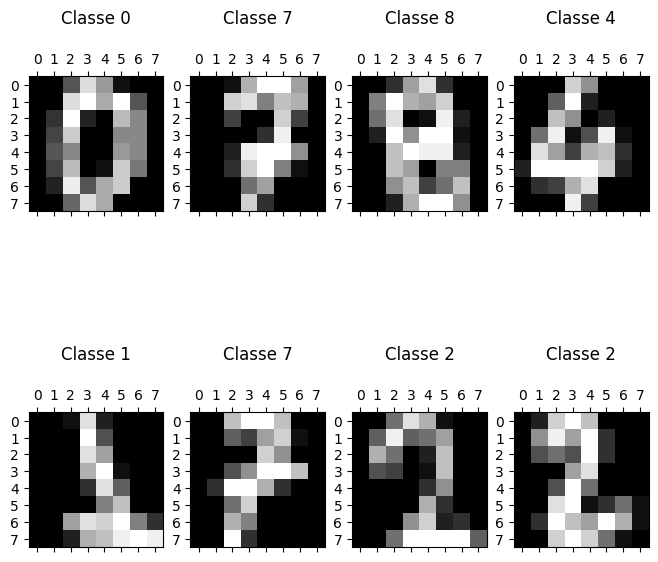

In [28]:
import sklearn
from sklearn import model_selection
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()
print('Shape do dataset:', digits.data.shape)
print('Podemos notar que ele já está no formato onde as colunas são pixels linearizados da imagem e cada linha é uma amostra (digito)!')

##### Vamos visualizar alguns exemplos ####
indices = [0, 300, 500,  800, 1000, 1200, 1400, 1600] #alguns indices aleatórios
figs, axs = plt.subplots(2, 4, figsize=(8, 8))

i = 0
for ind in indices:
  axs[int(i/4)][i%4].matshow(digits.images[ind], cmap = 'gray')
  axs[int(i/4)][i%4].set_title('Classe %s\n'%(digits.target[ind]))
  i+=1

plt.show()

Você deve agora realizar as seguintes tarefas:
   1. [x] Separar os dados em conjunto de treino e teste (já feito);
   2. [ ] Criar uma regra de classificação de novas imagens de dígitos se baseando no exemplo de Eigenfaces
   3. [ ] Use os primeiros $k$ autovetores da matriz de covariância entre os pixels para fazer esta regra declassificação. Você deve fazer seus cálculos com $k= 5,10,15,20$.
   4. [ ] Usando apenas a amostra de *teste*, crie uma tabela de contingência $10×10$ de confusão $C$.  Nesta matriz $C$ as linhas representam a classe verdadeira do dígito (de 0 a 9) e a coluna a classe em que ele foi alocado. Na entrada $C_{ij}$ você deve colocar o número de itens (ou imagens) que caíram naquela categoria cruzada. Crie a tabela para os quatro valores distintos de $k= 5,10,15,20$. Para isto, você pode usar a função ***plot_confusion_matrix*** disponibilizada neste notebook.
   5. [ ] Calcule e imprima a precisão média e o recall médio para cada $k$: A precisão média é a média aritmética da precisão das 10 classes e definida como: $pm=\frac{1}{10}\sum_{i=0}^{9}\frac{C_{ii}}{C_{i+}}$ com $C_{i+}$ sendo a soma da linha $i$ na matriz de confusão. Revocação média é a média aritmética da revocação das 10 classes e definida como: $rm=\frac{1}{10}\sum_{i=0}^{9}\frac{C_{ii}}{C_{i+}}$ com $C_{+i}$ sendo a soma da coluna $i$ na matriz de confusão. Você pode usar a função [sklearn.metrics.confusion_matrix()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) para gerar o array da matriz de confusão. Mais detalhes sobre precisão (precision) e revocação (recall) podem ser vistos no verbete Precision and recall na wikipedia. Ver também [http://www.text-analytics101.com/2014/10/computing-precision-and-recall-for.html](http://www.text-analytics101.com/2014/10/computing-precision-and-recall-for.html).

## Parte 1: Separando treino e teste

In [29]:
#PARTE 1 - Separando em conjunto de  treino e teste

X = digits.data
y = digits.target
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.1,random_state=1)

#Confirmando que temos todas as classes no conjunto de teste
y_aux = np.argsort(y_test)
y_test = y_test[y_aux]
X_test = X_test[y_aux]
items,counts = np.unique(y_test,return_counts=True)

print('Itens: ', items)
print('Número de vezes em que o item aparece:', counts)


Itens:  [0 1 2 3 4 5 6 7 8 9]
Número de vezes em que o item aparece: [20 19 21 22 18 17 16 21 15 11]


# ✅ Resolvendo os exercícios
## Letícia Ruas e Lívia Caroline

Primeiramente, com os dados devidamente separados entre treino e teste, devemos utilizar os dados de treino para criar um modelo, que depois será testado (com os dados de teste, como se espera). Para isso, o primento passo é centralizar os dados a partir de sua média. Ou seja, estamos pegando várias matrizes, calculando uma matriz média e então centrando todas as matrizes a partir dessa matriz média calculada.

## Parte 2: Classificação

In [30]:
# PARTE 2: Regra de classificação - centralizando

dig_media = np.mean(X_train.T, axis=1)

treino_centrado = (X_train - dig_media)


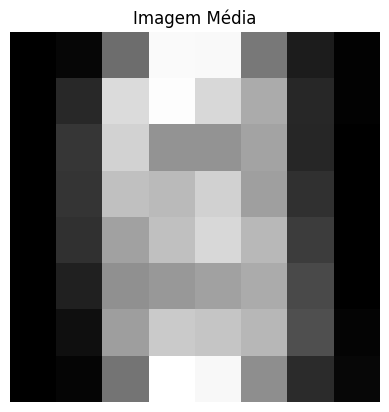

In [31]:
#Imagem média
import matplotlib.pyplot as plt

image = dig_media.reshape((8, 8))

plt.imshow(image, cmap='gray')
plt.title("Imagem Média")
plt.axis('off')
plt.show()


A imagem média representa a média de todos os dígitos presentes no conjunto de treino, pixel a pixel. Para obtê-la, foi calculada a média de cada uma das 64 posições (pixels) da imagem ao longo de todas as amostras de treino, resultando em um vetor `dig_media` de shape `(64,)`. Como cada imagem original tem **8 × 8 pixels** (64 no total), é possível aplicar o comando `reshape((8, 8))` para converter esse vetor unidimensional em uma matriz 2D que representa visualmente a média dos dígitos. A visualização dessa imagem nos mostra, de forma esmaecida, as regiões onde os dígitos geralmente aparecem — ou seja, as áreas mais escuras indicam os pixels mais frequentemente ativados nas imagens do dataset. Isso é útil para entender a estrutura média dos dados e serve como base para a centralização das imagens no PCA.


In [32]:
print("Shape treino centrado:", treino_centrado.shape)
#print("Shape teste centrado:", teste_centrado.shape)
print("Shape treino centrado.T:", treino_centrado.T.shape)
#print("Shape teste centrado.T:", teste_centrado.T.shape)


Shape treino centrado: (1617, 64)
Shape treino centrado.T: (64, 1617)


Agora, vamos calcular o PCA. Para a realização desse cálculo, vamos usar o exemplo do EigenFaces como base, usando arbitrariamente uma acurácia para a variância de 92% (apenas para não usar 90 exatamente igual ao exemplo).

In [33]:
from sklearn.decomposition import PCA
pca = PCA(0.92)
pca.fit(treino_centrado)

PCA(n_components=0.92)

#### Por que não usar o treino_centrado.T?

No caso das faces, cada linha representava uma pessoa e cada coluna era uma amostra de face dessa pessoa. Nesse caso, dos dígitos, cada coluna representa um dígito e cada linha é uma amostra para esse dígito. Ou seja, o pensamento de organização da matriz é inverso! Por isso também, no cálculo da média denotamos "ao inverso" as transpostas da matriz





Vamos entender o que os resultados do PCA dizem:

In [34]:
pca.components_.shape

(24, 64)

Ou seja, utilizando apenas 24 componentes, conseguimos representar bem os dados




In [35]:
pca.explained_variance_ratio_

array([0.14918903, 0.13661688, 0.11740211, 0.08395189, 0.05818173,
       0.04932564, 0.04275599, 0.03662491, 0.03389662, 0.03052956,
       0.02398452, 0.02238919, 0.01825177, 0.01769524, 0.01480953,
       0.01387509, 0.0131469 , 0.01230839, 0.01021894, 0.00922686,
       0.00892174, 0.00795638, 0.00765734, 0.0071793 ])

O array apresenta os autovalores em 24 componentes, ou seja, quanto cada componente contribui para a representação da variância! Com a soma disso, obtemos a porcentagem que esperamos (que foi definida no começo do processo de PCA)



In [36]:
sum(pca.explained_variance_ratio_ )

np.float64(0.9260955609399866)

## Parte 3: Definindo k-valores

A partir do PCA feito com o valor arbitrário de 92% de acurácia, podemos investigar quantos % da variância representamos com diferentes valores para k

In [37]:
# PARTE 3: Regra de classificação - PCA com k primeiros elementos
from sklearn.decomposition import PCA
import numpy as np
from scipy.spatial.distance import cdist

k = [5, 10, 15, 20]
auto_valores_k = []

for ki in k:
    # Armazena os ki primeiros autovalores na lista
    auto_valores_k.append(pca.explained_variance_ratio_[:ki])

    # Soma da variância explicada por ki componentes
    soma_variancia = np.sum(pca.explained_variance_ratio_[:ki])
    print(f'Utilizando os {ki} primeiros autovalores conseguimos representar {soma_variancia:.2%} da variância\n')



Utilizando os 5 primeiros autovalores conseguimos representar 54.53% da variância

Utilizando os 10 primeiros autovalores conseguimos representar 73.85% da variância

Utilizando os 15 primeiros autovalores conseguimos representar 83.56% da variância

Utilizando os 20 primeiros autovalores conseguimos representar 89.44% da variância



Esses resultados apresentam o seguinte: ao aplicar o PCA e manter 92% da variância explicada, conseguimos gerar um modelo que reduz a dimensionalidade dos dados de forma eficiente, preservando a maior parte da informação relevante. A seguir, utilizaremos esse modelo para classificar amostras com base nas médias das projeções por classe extraídas do conjunto de treino.

Esse modelo de PCA também nos permite avaliar, para diferentes valores de k (número de componentes principais), qual porcentagem da variância total conseguimos representar. Ou seja, ao analisarmos os primeiros k autovalores, podemos entender o quanto da estrutura dos dados está sendo mantida. E isso é o que a saída anterior mostrou.

## Por que não treinamos o PCA uma vez para cada k com `pca(n_components = k)`?

Porque é mais eficiente e informativo treinar o PCA uma única vez com todos os componentes (ou `PCA()` sem `n_components`) e, a partir disso, observar a variância explicada acumulada para diferentes valores de `k`.

Assim, podemos:

* Avaliar a contribuição de cada componente principal individualmente.
* Decidir quantos componentes utilizar com base na variância acumulada.
* Evitar treinar múltiplas vezes o PCA do zero, o que economiza processamento e garante consistência e possibilidade de comparação eficaz nos resultados.


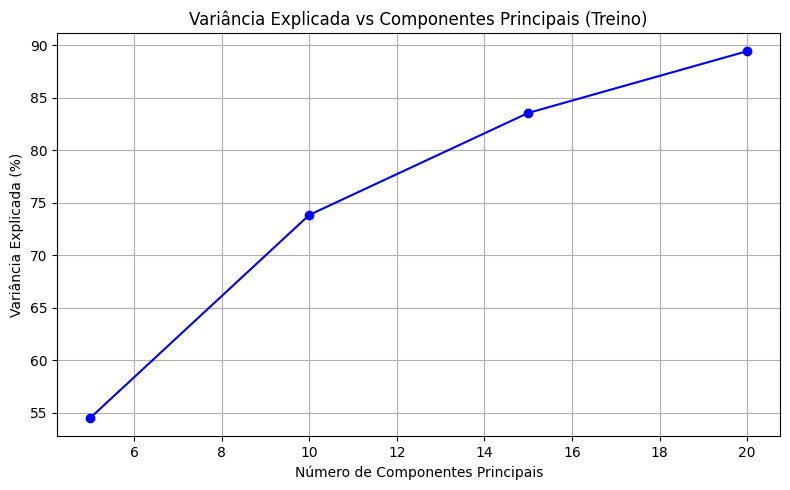

In [38]:
import matplotlib.pyplot as plt

# Dados
componentes = [5, 10, 15, 20]
variancia_explicada = [54.53, 73.85, 83.56, 89.44]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(componentes, variancia_explicada, marker='o', linestyle='-', color='b')

# Títulos e rótulos
plt.title('Variância Explicada vs Componentes Principais (Treino)')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada (%)')
plt.grid(True)

# Mostrar o gráfico
plt.tight_layout()
plt.show()


Assim como as autofaces, vamos criar os autodígitos: Vamos desempilhar os autovetores quebrando a coluna de cada um delesem 8 colunas de tamanho 8 cada uma. Com isto, cada autovetor dá origem a uma $imagemÂ'Â'$ ́com a mesma quantidade de pixels que as fotos de dígitos originais. Vamos chamar estas pseudo-fotos de **auto_dig**. Iremos utilizar apenas os 20 primeiros autovetores para isso.

In [39]:
auto_dig = []
for i in range(20):
    auto_dig.append(pca.components_[i])
auto_dig = np.asarray(auto_dig)

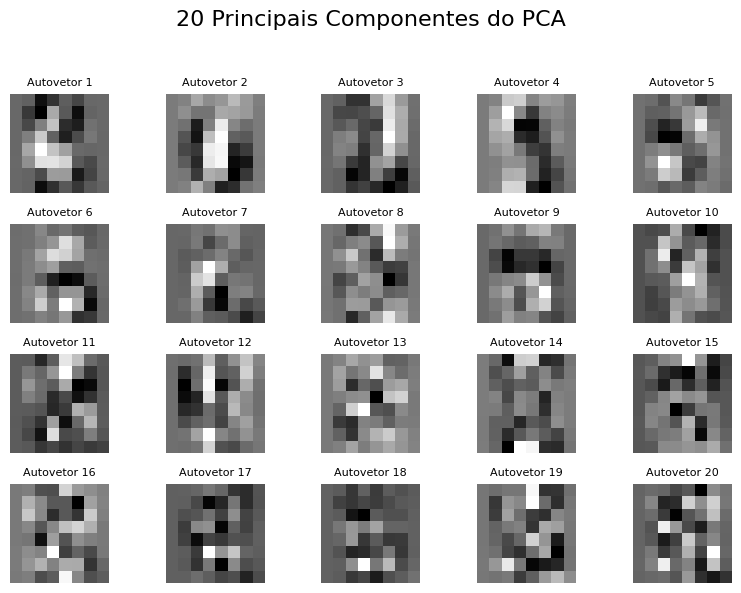

In [40]:
fig, axs = plt.subplots(4, 5, figsize=(8, 6))  # 4 linhas × 5 colunas
for i in range(20):
    ax = axs[i // 5, i % 5]
    ax.imshow(auto_dig[i].reshape((8,8)), cmap='gray')
    ax.set_title(f'Autovetor {i+1}', fontsize=8)
    ax.axis('off')

plt.suptitle("20 Principais Componentes do PCA", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [41]:
coeficientes_treino = []
coeficientes_teste = []

autovalores = pca.explained_variance_
autovetores = pca.components_
k = [5, 10, 15, 20]

# Calcula os coeficientes (projeções) para treino e teste
for ki in k:
    coef_train = autovetores[:ki, :] @ (X_train - dig_media).T
    coef_test = autovetores[:ki, :] @ (X_test - dig_media).T
    coeficientes_treino.append(coef_train)
    coeficientes_teste.append(coef_test)

# Calcula médias por classe para cada valor de k
coeficientes_medios = []

for idx, coef in enumerate(coeficientes_treino):  # percorre os coeficientes de cada k
    coef_medio_k = []
    for i in range(10):  # classes 0 a 9
        # índices onde a classe é i
        indices = np.where(y_train == i)[0]
        # média dos coeficientes dessa classe
        media_i = np.mean(coef[:, indices], axis=1)
        coef_medio_k.append(media_i)
    coeficientes_medios.append(np.array(coef_medio_k).T)


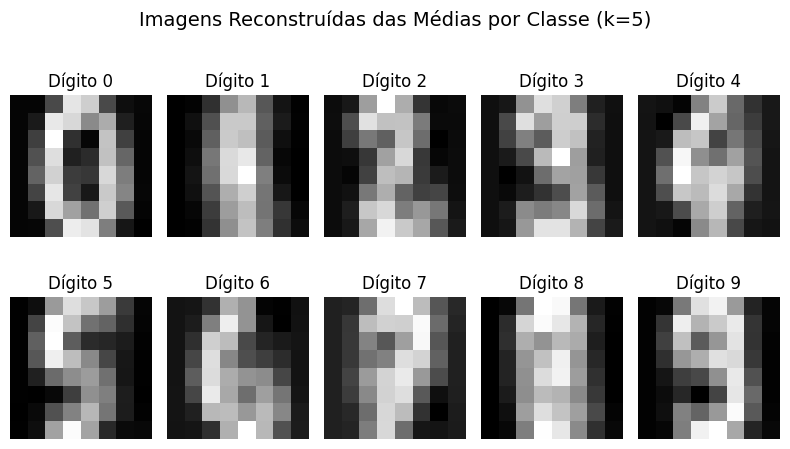

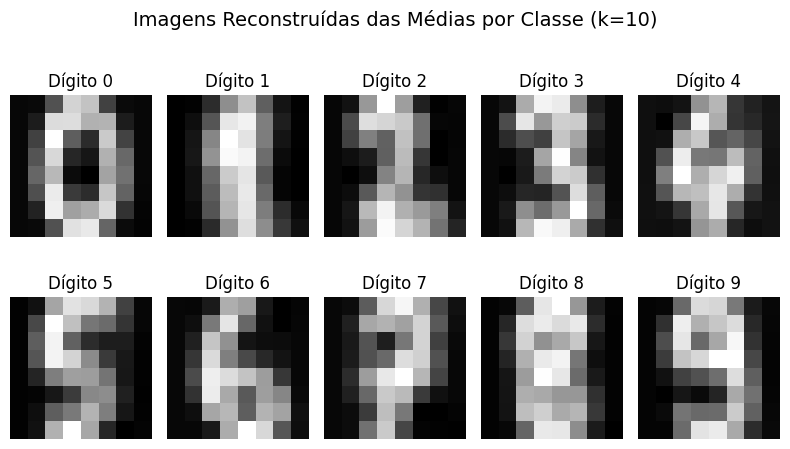

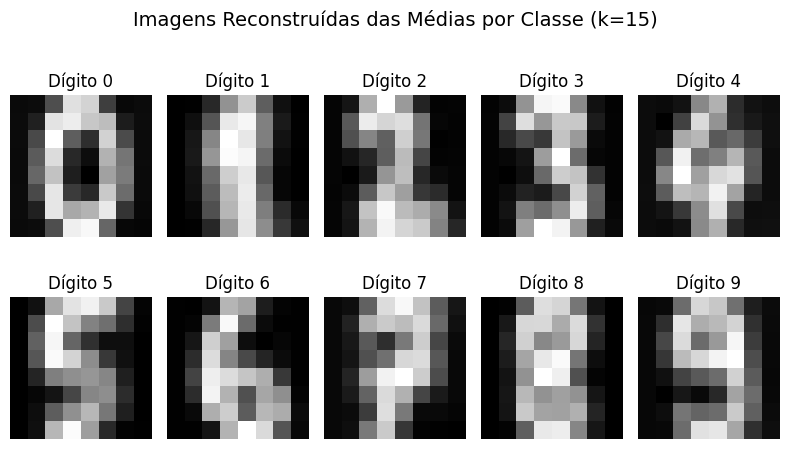

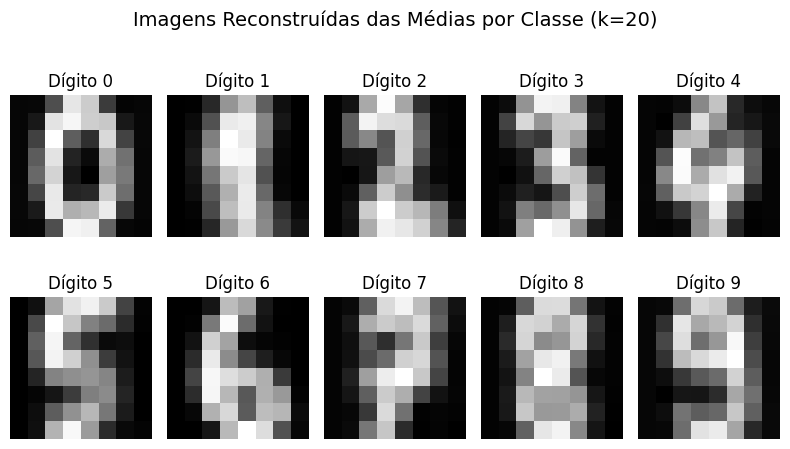

In [42]:
import matplotlib.pyplot as plt
import numpy as np

for ki in k:
  # Vou usar k = 20
  idx_k = k.index(ki)

  # Autovetores usados nesse k
  autovetores_k = autovetores[:k[idx_k], :]

  # Coeficientes médios das classes (shape: k_i x 10)
  coef_medio_k = coeficientes_medios[idx_k]  # shape: (k_i, 10)

  plt.figure(figsize=(8, 5))

  for i in range(10):
    # Reconstrói a imagem média da classe i
    imagem_reconstruida = autovetores_k.T @ coef_medio_k[:, i] + dig_media
    imagem_reconstruida = imagem_reconstruida.reshape(8, 8)

    # Plota
    plt.subplot(2, 5, i + 1)
    plt.imshow(imagem_reconstruida, cmap='gray')
    plt.title(f'Dígito {i}')
    plt.axis('off')

  plt.suptitle(f"Imagens Reconstruídas das Médias por Classe (k={ki})", fontsize=14)
  plt.tight_layout()
  plt.show()


Para cada valor de k, calculamos os coeficientes de treino e teste nos k autovetores principais da matriz de covariância dos dados centralizados, como no exemplo das faces. Depois, calculamos a média dos coeficientes projetados (representações no espaço PCA) para cada uma das 10 classes (dígitos de 0 a 9). A diferença daqui para o exemplo é que agora temos vários valores de k para os quais podemos calcular as predições, como faremos a seguir

In [43]:
# Para cada valor de k, calcula a predição com base na menor distância aos coeficientes médios
def predicao(valor_k, coeficientes_teste, coeficientes_medios):
    i = k.index(valor_k)
    c_teste = coeficientes_teste[i].T  # shape: (n_amostras, k_i)
    idx = []
    for j in range(c_teste.shape[0]):
        # Subtrai o vetor do teste de cada vetor médio de classe e calcula norma
        distancias = np.linalg.norm(coeficientes_medios[i] - c_teste[j][:, np.newaxis], axis=0)
        idx.append(int(np.argmin(distancias)))
    return idx


Agora podemos prever os valores com base em um valor para k!

## Parte 4: Tabela de contingência

[[2 0 0 0 0 0]
 [1 0 1 0 0 0]
 [0 0 1 1 0 0]
 [0 0 1 2 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 1]]


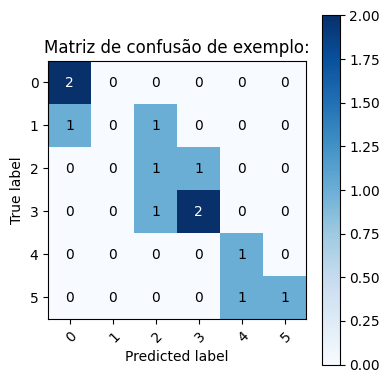

In [44]:
# Funcao para plotar a matriz de confusão - Você pode usá-la para visualizar o desempenho do seu classificador.
# confira um exemplo de uso no final desta célula

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = np.array(classes)
    classes = classes[unique_labels(y_true, y_pred)]


    fig, ax = plt.subplots(figsize = (4,4))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(cm.shape[0] -1 + 0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.show()

############################ Exemplo de como usar a função:############################

y_true = [0,0,3,5,2,1,3,4,5,2,1,3] # Aqui são os valores verdadeiros dos dígitos
y_pred = [0,0,3,4,3,2,3,4,5,2,0,2] # Aqui são os valores preditos pelo seu método (que vão ser gerados por ele, mas neste exemplo estamos colocando na mão)
classes = [0,1,2,3,4,5] # Classes possíveis: nesse exemplo de 0 a 5

#Aqui só obtemos o numpy array da matriz e exibimos (útil para o exercício 5)
cm_array = confusion_matrix(y_true, y_pred)
print(cm_array)

#Aqui plotamos a matriz em um formato bonito :) (útil para o exercício 4)
plot_confusion_matrix(y_true, y_pred, classes, title = "Matriz de confusão de exemplo:")

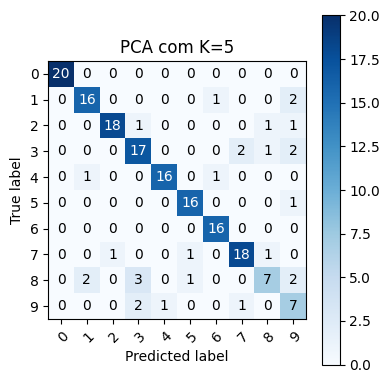

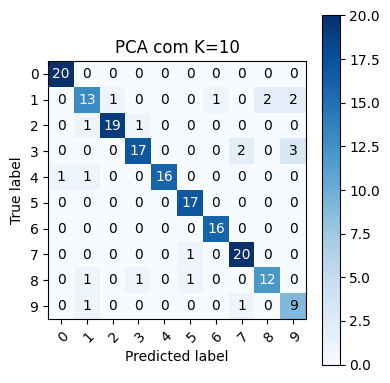

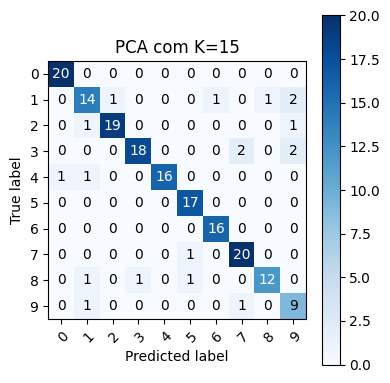

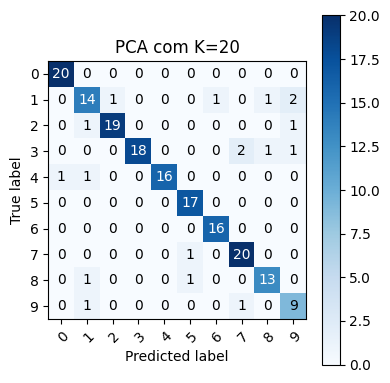

In [45]:
p_5 = predicao(5, coeficientes_teste, coeficientes_medios)
plot_confusion_matrix(y_test, p_5, items, title="PCA com K=5")

p_10 = predicao(10, coeficientes_teste, coeficientes_medios)
plot_confusion_matrix(y_test, p_10, items, title="PCA com K=10")

p_15 = predicao(15, coeficientes_teste, coeficientes_medios)
plot_confusion_matrix(y_test, p_15, items, title="PCA com K=15")

p_20 = predicao(20, coeficientes_teste, coeficientes_medios)
plot_confusion_matrix(y_test, p_20, items, title="PCA com K=20")

In [46]:
matrix_confusao_5 = confusion_matrix(y_test, p_5)
matrix_confusao_10 = confusion_matrix(y_test, p_10)
matrix_confusao_15 = confusion_matrix(y_test, p_15)
matrix_confusao_20 = confusion_matrix(y_test, p_20)

As matrizes de confusão apresentadas mostram a performance do classificador de maneira clara. Com K=5, o classificador tem dificuldade em distinguir corretamente várias classes, especialmente os dígitos 8 e 9, que sofrem confusão com outras classes, como o 3 - no caso do 8 -, tornando os valores da diagonal principal mais baixos (nesse caso, 7). Isso indica que 5 componentes principais são insuficientes para capturar a variabilidade necessária para uma boa separação entre as classes.

À medida que o valor de K aumenta (10, 15 e 20), a acurácia do classificador melhora gradualmente. Apesar de algumas variações, como o 13 que aparece no 1,1 para o k = 10, ao fim do processo a matriz se aproxima da identidade, o que pode ser identificado visualmente pelas cores mais fortes da diagonal principal e permite concluir que com 20 componentes principais o modelo já funciona de maneira satisfatória. Isso é confirmado pelo resultado que chegamos anteriormente, onde 20 componentes representam bem quase 90% da variância.


## Parte 5: Precisão para k

In [47]:
def precisao(matriz_confusao, classe):
    return matriz_confusao[classe, classe] / np.sum(matriz_confusao[classe, :])

def recall(matriz_confusao, classe):
    return matriz_confusao[classe, classe] / np.sum(matriz_confusao[:, classe])


In [48]:
matrizes_confusao = [matrix_confusao_5, matrix_confusao_10, matrix_confusao_15, matrix_confusao_20]


In [49]:
for ki in k:
  idx_k = k.index(ki)
  matriz_confusao = matrizes_confusao[idx_k]

  precisoes = []
  recalls = []
  for i in classes:
    precisoes.append(precisao(matriz_confusao, i))
    recalls.append(recall(matriz_confusao, i))

  media_recall = round(np.mean(np.asarray(recalls)),2)
  media_precisao = round(np.mean(np.asarray(precisoes)),2)

  print(f"Para o valor de k = {ki}:")
  print(f"Precisão média: {media_precisao}")
  print(f"Recall médio: {media_recall}\n")

Para o valor de k = 5:
Precisão média: 0.88
Recall médio: 0.89

Para o valor de k = 10:
Precisão média: 0.88
Recall médio: 0.91

Para o valor de k = 15:
Precisão média: 0.89
Recall médio: 0.92

Para o valor de k = 20:
Precisão média: 0.89
Recall médio: 0.93



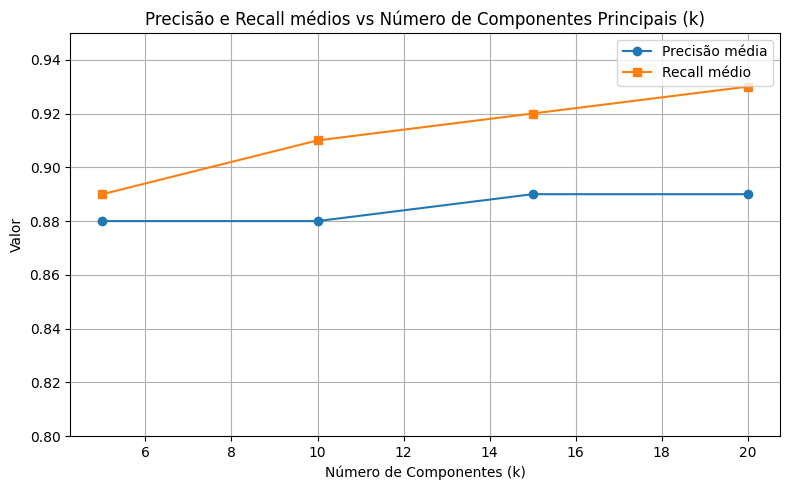

In [50]:
import matplotlib.pyplot as plt

ks = [5, 10, 15, 20]
precisoes = [0.88, 0.88, 0.89, 0.89]
recalls = [0.89, 0.91, 0.92, 0.93]

plt.figure(figsize=(8, 5))
plt.plot(ks, precisoes, marker='o', label='Precisão média')
plt.plot(ks, recalls, marker='s', label='Recall médio')

plt.title('Precisão e Recall médios vs Número de Componentes Principais (k)')
plt.xlabel('Número de Componentes (k)')
plt.ylabel('Valor')
plt.ylim(0.80, 0.95)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Os resultados obtidos revelam uma evolução significativa no desempenho do classificador na medida que o número de componentes principais aumenta. Para
k = 5, a precisão e o recall médios já são relativamente altos, o que demonstra que mesmo uma representação menor dos dados já é capaz de captar muitas informações relevantes.

No entanto, observa-se uma melhora nos valores de recall ao aumentar k para 10 e para 15. A precisão também se mantém estável ou levemente superior nesses casos. Para
k = 20, os valores se estabilizam, indicando que a adição de mais componentes não necessariamente traz ganhos significativos.

Esses resultados confirmam que a escolha de um valor de
k entre 15 e 20 representa um bom compromisso entre complexidade do modelo e desempenho de classificação.

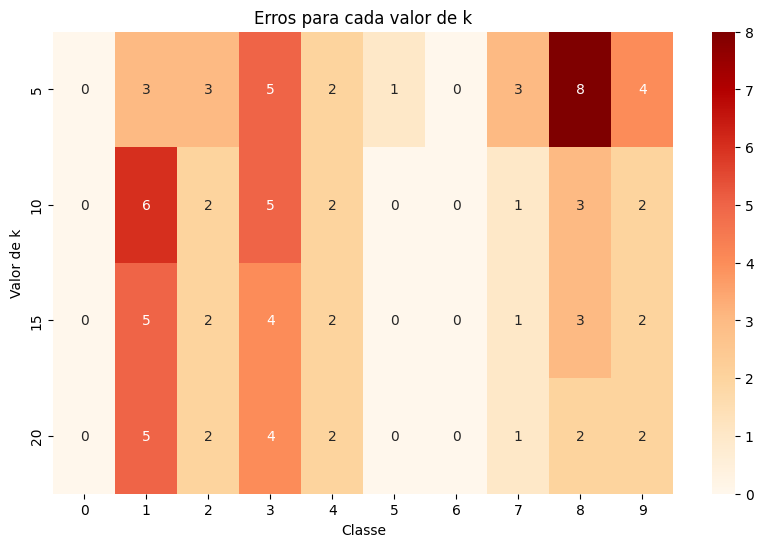

In [51]:
import seaborn as sns

erro_por_classe = []
predicoes = [p_5, p_10, p_15, p_20]

for preds in predicoes:
    cm = confusion_matrix(y_test, preds)
    erros = cm.sum(axis=1) - np.diag(cm)
    erro_por_classe.append(erros)

plt.figure(figsize=(10, 6))
sns.heatmap(erro_por_classe, annot=True, cmap="OrRd", fmt="d",
            xticklabels=items, yticklabels=ks)
plt.title("Erros para cada valor de k")
plt.xlabel("Classe")
plt.ylabel("Valor de k")
plt.show()



# Conclusão
Este projeto mostrou que a Análise de Componentes Principais (PCA) tem diversas funcionalidades, como a de reconhecer dígitos escritos à mão. O PCA ajudou a diminuir a quantidade de dados sem perder as informações mais importantes para a identificação dos números. Com isso, conseguimos representar bem os dígitos e obter bons resultados na classificação.

Testamos diferentes quantidades de componentes principais e percebemos que um número moderado deles pode já ser suficiente para capturar a maior parte da informação relevante e garantir um bom desempenho.

Assim, o PCA se mostrou uma ferramenta eficaz para simplificar os dados e ajudar na identificação dos dígitos manuscritos.